<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week7%20/BiDirectionalRNN/Sarkasme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, Dense, LSTM, GRU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [8]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
# Load the dataset
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
df = pd.read_json(url, lines=True)


In [10]:
# Display info about the dataset
print(f"Dataset shape: {df.shape}")
print(df.head())
print(df['is_sarcastic'].value_counts())

Dataset shape: (26709, 3)
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


In [11]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and extra whitespace
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]

    return ' '.join(filtered_text)


In [15]:
# Apply preprocessing to headlines
df['processed_headline'] = df['headline'].apply(preprocess_text)



In [16]:
# Split data into training and testing sets
X = df['processed_headline'].values
y = df['is_sarcastic'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Tokenize and pad sequences
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [18]:
# Define the BiRNN model
def create_birnn_model(vocab_size, embedding_dim=128, rnn_units=64, dropout_rate=0.3,
                       learning_rate=0.001, rnn_type="LSTM"):

    inputs = Input(shape=(max_len,))
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

    if rnn_type == "LSTM":
        birnn = Bidirectional(LSTM(rnn_units, return_sequences=True))(embedding)
        birnn = Bidirectional(LSTM(rnn_units))(birnn)
    else:  # GRU
        birnn = Bidirectional(GRU(rnn_units, return_sequences=True))(embedding)
        birnn = Bidirectional(GRU(rnn_units))(birnn)

    dropout = Dropout(dropout_rate)(birnn)
    outputs = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [19]:
# Create a BiRNN model
vocab_size = len(tokenizer.word_index) + 1
model = create_birnn_model(vocab_size)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 128)       │     3,156,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,354,753 (12.80 MB)

 Trainable params: 3,354,753 (12.80 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)


In [21]:
# Train the model
history = model.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6293 - loss: 0.6197

134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.6305 - loss: 0.6186 - val_accuracy: 0.7950 - val_loss: 0.4320
Epoch 2/15
132/134 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8797 - loss: 0.2959

134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8796 - loss: 0.2959 - val_accuracy: 0.8081 - val_loss: 0.4368
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9379 - loss: 0.1685 - val_accuracy: 0.7995 - val_loss: 0.5247
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9651 - loss: 0.1021 - val_accuracy: 0.7934 - val_loss: 0.6738


In [22]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train_pad, y_train)
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")


668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8886 - loss: 0.3045
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7885 - loss: 0.4415
Training Accuracy: 0.8665
Testing Accuracy: 0.7931


In [24]:
# Get predictions
y_pred = model.predict(X_test_pad)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Calculate metrics
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc_score = roc_auc_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Precision: 0.8110
Recall: 0.6897
F1 Score: 0.7455
AUC: 0.8777


In [25]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

In [26]:
# Visualization functions
def plot_metrics(history):
    """Plot training & validation accuracy and loss curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [27]:
def plot_confusion_matrix(cm):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [28]:
def plot_roc_curve(y_test, y_pred):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

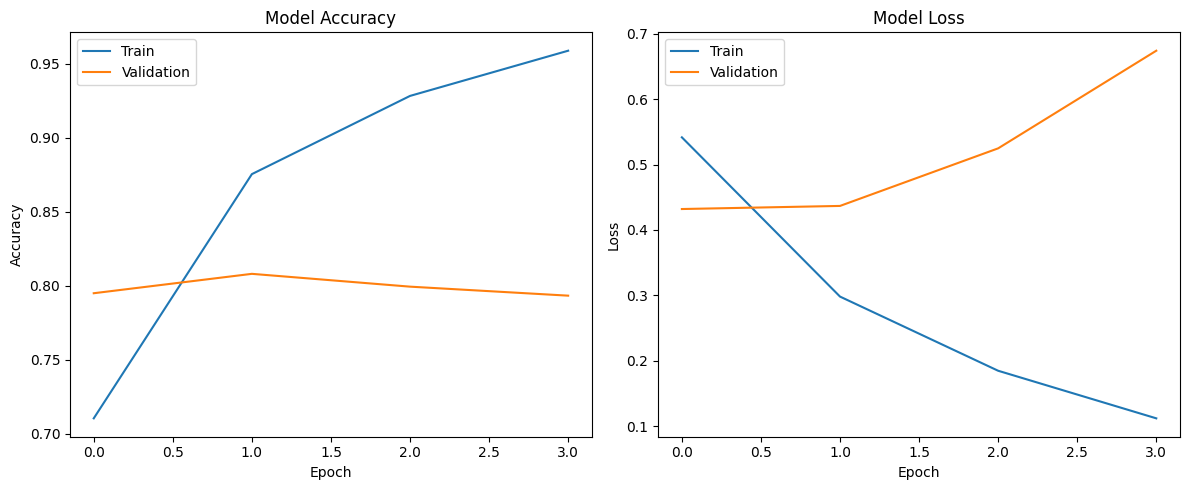

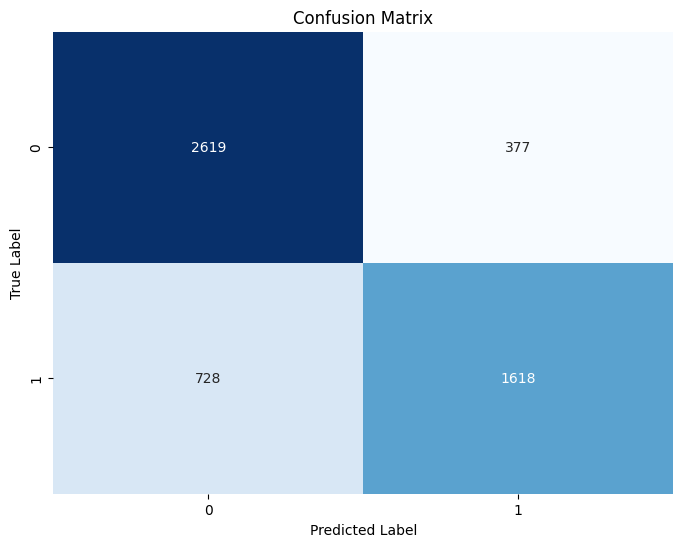

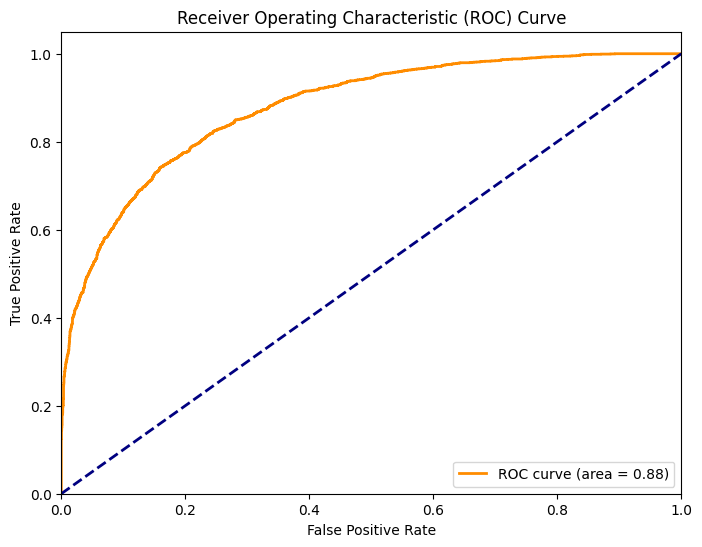

In [29]:
# Plot metrics
plot_metrics(history)
plot_confusion_matrix(cm)
plot_roc_curve(y_test, y_pred.flatten())

In [30]:
# Hyperparameter tuning function
def hyperparameter_tuning():
    # Parameters to try
    embedding_dims = [64, 128, 256]
    rnn_units = [32, 64, 128]
    dropout_rates = [0.2, 0.3, 0.4]
    learning_rates = [0.01, 0.001, 0.0001]
    rnn_types = ["LSTM", "GRU"]

    # Store results
    tuning_results = []

    best_accuracy = 0
    best_params = None

    # Simplified version (try a subset of combinations)
    for embedding_dim in embedding_dims:
        for rnn_unit in rnn_units:
            for rnn_type in rnn_types:
                # Create model with current parameters
                model = create_birnn_model(
                    vocab_size=vocab_size,
                    embedding_dim=embedding_dim,
                    rnn_units=rnn_unit,
                    dropout_rate=0.3,  # Fixed for simplicity
                    learning_rate=0.001,  # Fixed for simplicity
                    rnn_type=rnn_type
                )

                # Train model with early stopping
                history = model.fit(
                    X_train_pad, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
                    verbose=0
                )

                # Evaluate model
                _, train_accuracy = model.evaluate(X_train_pad, y_train, verbose=0)
                _, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)

                # Store result
                result = {
                    'embedding_dim': embedding_dim,
                    'rnn_units': rnn_unit,
                    'rnn_type': rnn_type,
                    'dropout_rate': 0.3,
                    'learning_rate': 0.001,
                    'train_accuracy': train_accuracy,
                    'test_accuracy': test_accuracy
                }

                tuning_results.append(result)

                # Check if this is the best model so far
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = result

                print(f"Params: {result}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(tuning_results)

    print("\n===== Hyperparameter Tuning Results =====")
    print(f"Best parameters: {best_params}")
    print(f"Best test accuracy: {best_accuracy:.4f}")

    return results_df, best_params

In [31]:
# Train final model with best parameters (after tuning)
final_model = create_birnn_model(
    vocab_size=vocab_size,
    embedding_dim=128,      # Replace with best_params['embedding_dim']
    rnn_units=64,           # Replace with best_params['rnn_units']
    dropout_rate=0.3,       # Replace with best_params['dropout_rate']
    learning_rate=0.001,    # Replace with best_params['learning_rate']
    rnn_type="LSTM"         # Replace with best_params['rnn_type']
)


In [32]:
# Train the final model
final_history = final_model.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6311 - loss: 0.6230 - val_accuracy: 0.7936 - val_loss: 0.4301
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8757 - loss: 0.3096 - val_accuracy: 0.8000 - val_loss: 0.4461
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9255 - loss: 0.1973 - val_accuracy: 0.7922 - val_loss: 0.5060
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9564 - loss: 0.1324 - val_accuracy: 0.7911 - val_loss: 0.5964


In [34]:
# Evaluate final model
train_loss, train_accuracy = final_model.evaluate(X_train_pad, y_train)
test_loss, test_accuracy = final_model.evaluate(X_test_pad, y_test)

print("\n===== Final Model Results =====")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

668/668 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.8873 - loss: 0.2998
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7831 - loss: 0.4474

===== Final Model Results =====
Training Accuracy: 0.8656
Testing Accuracy: 0.7881


In [35]:
# Get predictions
y_pred = final_model.predict(X_test_pad)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

# Calculate metrics
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc_score = roc_auc_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc_score:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Precision: 0.7463
Recall: 0.7839
F1 Score: 0.7647
AUC: 0.8742


In [36]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)


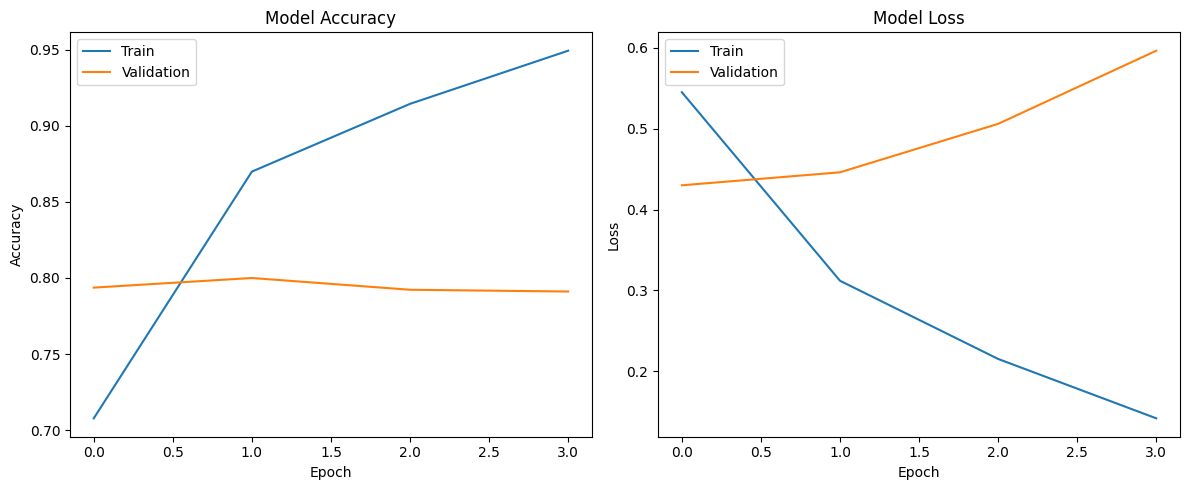

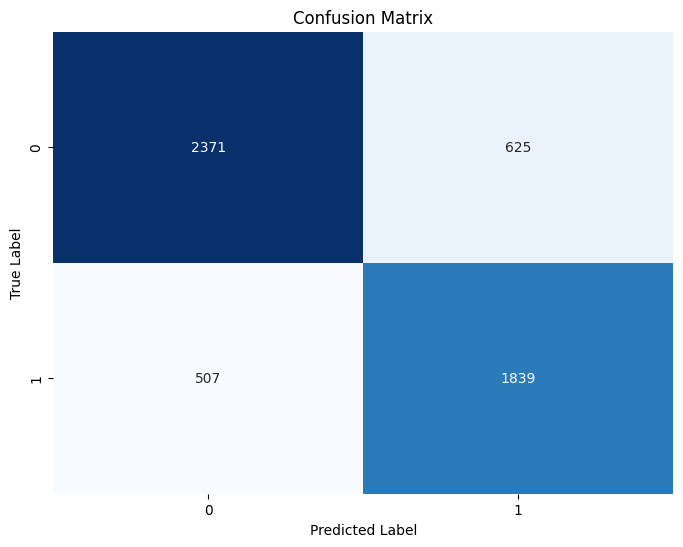

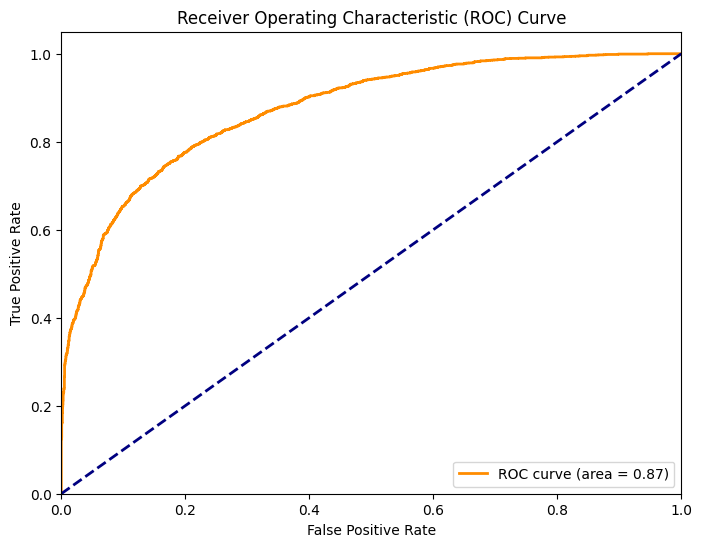

In [37]:
# Plot final metrics
plot_metrics(final_history)
plot_confusion_matrix(cm)
plot_roc_curve(y_test, y_pred.flatten())


In [38]:
def predict_sarcasm(headline):
    # Preprocess the headline
    processed = preprocess_text(headline)
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([processed])
    # Pad sequence
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    # Predict
    prediction = final_model.predict(padded)[0][0]

    print(f"Headline: {headline}")
    print(f"Prediction: {'Sarcastic' if prediction > 0.5 else 'Not Sarcastic'} (Probability: {prediction:.4f})")


In [39]:
# Test with sample headlines
print("\n===== Sample Predictions =====")
predict_sarcasm("Scientists discover new planet that might support life")
predict_sarcasm("Local man loses last bit of hope he didn't even know he had")


===== Sample Predictions =====
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Headline: Scientists discover new planet that might support life
Prediction: Sarcastic (Probability: 0.8528)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Headline: Local man loses last bit of hope he didn't even know he had
Prediction: Sarcastic (Probability: 0.9932)
